In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


from flame_net.lib_uti import count_learnable_params
from flame_net.libSiva import CSolverSiva
#from flame_net.uti_plot import *
import os

from flame_net.libSiva import libSiva
from flame_net.libData import libData
from flame_net.libcfdData import libcfdData

# to extract an isoline 
#import matplotlib._cntr as cntr
import pickle

%matplotlib inline

#np.random.seed(seed=1653)
from torch.profiler import profile, record_function, ProfilerActivity


In [2]:
torch.__version__

'1.13.1'

In [3]:
device = torch.device('cuda')
bRNN=False
T_in=1
data_channel = 1 # model.data_channel


In [4]:
params = {
    'Nx':256, 
    'yB':np.array( [-0.9, 2.3])*np.pi, 
    'ThicknessScale': 2,
    'cfd_init':'L1536_rho8',
}

In [5]:
# models[0] = {          'model_name_detail':'pFNO2D_tks2_m64_64w20cfdL320_rho8_L1536_rho8ED6_share_skip_o10_ep900', 
#         'nu':None,
#         'sys_type':'cfd',
#         'pdePara':None,
#         'Nx':256, 'Ny':256, 'yB':np.array( [-0.9, 2.3])*np.pi,
#         'nStep':1,'Tout':10}

In [6]:
list__init_str = ['rand_simple','rand_simple','rand_simple','rand_simple' ]
cfdsys_all = [
  #{'cfd':'L1536_rho8', 'nu':0.025, 'SivaEq':CSolverSiva('MS_1stEuler',[0.02],1), 'N':512 ,'list_randseed':[26,37,2916,386] },
  #{'cfd':'L512_rho8', 'nu':0.025, 'SivaEq':CSolverSiva('MS_1stEuler',[0.02],1), 'N':512 ,'list_randseed':[26,37,2936,3821] }
  {'cfd':'L1536_rho8', 'nu':0.025, 'SivaEq':CSolverSiva('MS_RK4',[0.025],1),'list_randseed':[258,827,178,71] },
  {'cfd':'L512_rho8', 'nu':0.025, 'SivaEq':CSolverSiva('MS_RK4',[0.025],1), 'list_randseed':[161,1371,161,13816] },
  {'cfd':'L320_rho8', 'nu':0.025, 'SivaEq':CSolverSiva('MS_RK4',[0.025],1), 'list_randseed':[1261,1371,161,13816] }
]

siva_sys_name= MS_RK4
N= 256 ,dt_Output= 0.015 ,self.list_para = [0.025] ,ActiveNoise_Amplitude=0.000000,stepfeq=1,k = 0 
siva_sys_name= MS_RK4
N= 256 ,dt_Output= 0.015 ,self.list_para = [0.025] ,ActiveNoise_Amplitude=0.000000,stepfeq=1,k = 0 
siva_sys_name= MS_RK4
N= 256 ,dt_Output= 0.015 ,self.list_para = [0.025] ,ActiveNoise_Amplitude=0.000000,stepfeq=1,k = 0 


In [7]:
#512 , 819
#256, 409

models=[
    #Fourier2D_m64_64w20cfdL320_rho8_L512_rho8_L768_rho8_L1536_rho8_nPara2D3_share_skip_o8_best
    #pFNO2D_tanh_m64_64w20cfdL320_rho8_L1536_rho8_share_skip_o8_ep700
    #pFNO2D_m64_64w20cfdL320_rho8_L1536_rho8_share_skip_o8
    #pFNO2D_m64_64w20cfdL320_rho8_L1536_rho8_share_skip_o8_ep200
    #pFNO2D_tks2_m64_64w20cfdL320_rho8_L1536_rho8_share_skip_o8_ep900
    #pFNO2D_tanh_tks4_m64_64w20cfdL320_rho8_L1536_rho8_share_skip_o8_ep400
        { 
         #'model_name_detail':'std_pFNO2D_tks2_m64_64w20cfdL320_rho8_L1536_rho8D6_share_o8', 
         'model_name_detail':'pFNO2D_tks2_m64_64w20cfdL320_rho8_L1536_rho8ED6_share_skip_o10_ep900', 
         #'model_name_detail':'pFNO2D_dct_tks2_m64_64w20cfdL320_rho8_L1536_rho8ED6_share_skip_o10', 
         #'model_name_detail':'std_pFNO2D_tks2_m64_64w20cfdL320_rho8_L1536_rho8ED6_share_skip_o8', 
         #'model_name_detail':'N512pFNO2D_m64_64w20cfdL512_rho8_L1536_rho8_share_skip_o8',
         'nu':None,
         'sys_type':'cfd',
         'pdePara':None,
         'Nx':256, 'Ny':256, 'yB':np.array( [-0.9, 2.3])*np.pi,
         #'Nx':256, 'Ny':409, 'yB':np.array( [-0.9, 2.3])*np.pi,
         'nStep':1,'Tout':8},
        {'model_name_detail':'std2_pConv2D_tks2_cfdL320_rho8_L1536_rho8d6_inception_less_o10','nu':None,
         'sys_type':'cfd',
         'pdePara':None,
         'Nx':256, 'Ny':256, 'yB':np.array( [-0.9, 2.3])*np.pi,
         #'Nx':512, 'Ny':512, 'yB':np.array( [-0.7, 2.5])*np.pi,
         'nStep':1,'Tout':10}
        #{'model_name_detail':'Fourier_m32w20nu07_share_skip'               ,'nu':0.07,'nStep':1,'Tout':20},
]


#list__init_str = ['rand_FFT_2_8','rand_simple','rand_FFT_2_8','rand_simple' ]



In [8]:
def load_pkl( m ):
    str_filename = m['model_name_detail'] 
    if str_filename.find('_ep') >=0:         str_filename  = str_filename[ : str_filename.find('_ep') ]
    if str_filename.find('_best')>=0:        str_filename  = str_filename[ : str_filename.find('_best') ]
    open_file=open('./checkpoints/'+str_filename+ 'trainlog.pkl','rb')
    output_dict= pickle.load(open_file)
    open_file.close()
    train_residual = np.array ( [ os for os  in output_dict['list_output_info'] ] )
    return train_residual 
    
def plot_training_resid( m, list_iy=[4,5], ys='log',ix=0):
    train_residual = load_pkl( m)
    line_style = ['r-', 'g-.','b--','k.']
    for idx, y in enumerate(list_iy):
        plt.plot( train_residual[:,ix], train_residual[:,y], line_style[idx])
        #plt.plot( train_residual[:,ix], train_residual[:,y],'b-')
    plt.yscale(ys)
    
    return [ train_residual[:, y ][-1] for  y in list_iy ]

def print_train_info( list_iy=[2,3,1], models=models ):
    for idx, m in enumerate( models):
        train_residual = load_pkl( m)
        #----------------
        if  'FNO' in m['model_name_detail']:
            method='FNO'
        elif  'Conv' in m['model_name_detail']:
            method='Conv'
        #----------------
        print(idx, method, m['nu'], m['nStep'] ,m['Tout'],  [ train_residual[:, y ][-1] for  y in list_iy ] ) 
        
def print_extra_train_info( list_iy=[4,5,1], models=models ):
    for idx, m in enumerate( models):
        train_residual = load_pkl( m)
        #----------------
        if  'FNO' in m['model_name_detail']:            method='FNO'
        elif  'Conv' in m['model_name_detail']:          method='Conv'
        #----------------
        print(idx, method, m['nu'], m['nStep'] ,m['Tout'],  [ train_residual[:, y ][-1] for  y in list_iy ] ) 

[0.009389905736872659]

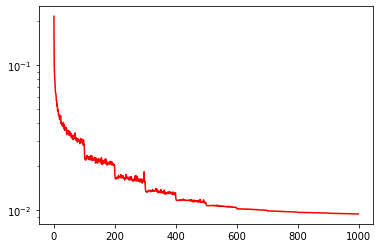

In [9]:
plot_training_resid (  models[0], [2],  ys='log' )

In [10]:
def load_sys_xy_curv(sys):
    picklefilename = './Data_PRE_LaminarFlame/' + sys['cfd']+'.pkl'
    open_file = open(picklefilename, "rb")
    loaded_list = pickle.load(open_file)
    open_file.close()
    ##############################################
    N_mesh   = loaded_list['N']
    x        = np.arange(N_mesh)
    ################################################
    dyScale  = loaded_list['dyScale']
    #y3       = loaded_list['y3']/dyScale
    xy_curv  = loaded_list['xy_curv']
    y_simple = loaded_list['y_simple'][::10]/dyScale
    y0Ref    = np.average( y_simple,  axis = 1)
    ################################################
    x        =                         x /N_mesh         #  * 2*np.pi
    y_simple = ( y_simple- y0Ref.reshape(-1,1) )  /N_mesh  #  * 2*np.pi
    for idx, xy_each in enumerate( xy_curv ):
        xy_each[:,0] =( ( xy_each[:,0]/dyScale) - y0Ref[idx] ) /N_mesh  #*2*np.pi
        xy_each[:,1] =    xy_each[:,1]                         /N_mesh  #*2*np.pi
        xy_each[:,0] *= 2*np.pi
        xy_each[:,1] = (xy_each[:,1]-0.5)*2*np.pi
    ##############################################
    #Ly = max_y-min_y
    sys['xyCurv'] = xy_curv
    return sys

for sys in cfdsys_all:
    sys = load_sys_xy_curv(sys)

In [11]:
#CSolverSiva('MS_1stEuler',[0.02],1).get_init_func_from_txt( 'rand_simple' )()

In [12]:
def get_2d_cfd_sys( cfd, cfdsys_all=cfdsys_all):
    for sys in cfdsys_all:
        if sys['cfd']== cfd :       return sys
    print(cfd)
    raise ValueError('did not find cfd sys')
    
def get_rand_1d_d0(sys,list__init_str=list__init_str):
    d0_all=[]
    for  init_str, randseed in zip( list__init_str, sys['list_randseed'] )  :
        np.random.seed(seed= randseed )
        d0 = sys['SivaEq'].get_init_func_from_txt( init_str )( {'siva_sys_name':sys['SivaEq'].siva_sys_name,'para_value':0.02 } )
        d0_all.append(d0)
    return  np.array( d0_all )

In [13]:

def load_model( model_name_detail):
    LocalFull_filename_Saved_Model =  './checkpoints/' + model_name_detail
    model = torch.load( LocalFull_filename_Saved_Model, map_location='cuda')
    print(model_name_detail, ' loaded in: count_learnable_params =' + str( count_learnable_params(model) ))
    return model

def get_model(name, models=models, bLoadModel=True):
    if 'pfno' in name.casefold():       name_internal = 'pfno2d'
    elif 'pcnn' in name.casefold():     name_internal = 'conv'
        
    for m in models:
        if name_internal in m['model_name_detail'].casefold(): 
            if 'model' not in m  and bLoadModel==True:                m['model'] = load_model( m['model_name_detail'] )
            return m
    raise ValueError('did not find model') 


In [14]:
def extract_line( G ):
    surf_i = []
    for i in range(G.shape[0]):
        A_i = []
        np.diff(G[i,:])
        surf_j.append( )
    return 


In [15]:
def torch_split_index(A):
    len_A = len(A)
    mask_A = A<0
    idx_change_A =  torch.bitwise_xor( mask_A[:-1] , mask_A[1:] )
    
    # splited regions
    A_regs = torch.where( idx_change_A==True ) [0]  
    
    j0 = torch.ones( 1+len(A_regs) , dtype=int)
    j1 = torch.ones( 1+len(A_regs) , dtype=int)

    j0[0]   = 0           ;  j0[1:] = A_regs
    j1[:-1] = A_regs+1 +1 ;  j1[-1] = len_A-1 + 1
    
    return j0, j1

def torch_DataLimiter(A):
    if A[-1] < 0 : 
        if A[0] < 0 :
            id_max = torch.argmax( A )
            A[      :id_max] = torch.cummax ( A[      :id_max]                , dim = 0 )[0]
            A[id_max:      ] = torch.cummax ( A[id_max:      ].flip(dims=[0]) , dim = 0 )[0].flip(dims=[0])
        elif A[0] > 0.5:
            A = torch.cummax ( A.flip(dims=[0])   , dim = 0 )[0].flip(dims=[0])
        else: 
            A = torch.cummin ( A  , dim = 0)[0] 
    else: # A[-1] > 0 
        if A[0] > 0:
            id_min = torch.argmin( A )
            A[      :id_min] = torch.cummin ( A[      :id_min]                 , dim = 0)[0]
            A[id_min:      ] = torch.cummin ( A[id_min:      ].flip(dims=[0])  , dim = 0)[0].flip(dims=[0])
        else: 
            assert False, 'A[0]'
    return A
def correct_G( G , ratio_j = 1 ):
    G_new= np.zeros_like(G)
    Nx,Ny = G.shape
    for i in range( Nx ):
        Gi = G[i,:]
        js_0 = np.where( Gi[:-1]*Gi[1:] <=0 )
        Gs_0 = np.arctanh( Gi[:-1][js_0])
        Gs_1 = np.arctanh( Gi[1: ][js_0] )
        d_j = Gs_0 / (Gs_0- Gs_1) 
        js  = js_0[0]+d_j
        # ----------
        j_seg = js.astype(int)
        G_new[i, :j_seg[0]+1 ] = js[0] - np.arange( j_seg[0]+1 )
        for k in range( len(js) - 1 ):
            j_seg_range  = np.arange(j_seg[k]+1, j_seg[k+1]+1 ) 
            G_new[i, j_seg[k]+1:j_seg[k+1]+1 ] =  - (-1)**(k) *np.minimum( j_seg_range - js[k] ,   js[k+1]  -  j_seg_range  )
        G_new[i, j_seg[-1]+1: ] =  -( np.arange( j_seg[-1]+1,  Ny ) - js[-1] )
    G_new = np.tanh( G_new / ratio_j)
    return G_new

In [16]:

def update_model_pred(m):

    m['model'] = load_model( m['model_name_detail'] )
    m['x']     = libSiva.get_x( m['Nx'] ) 
    m['y']     = np.linspace(  m['yB'][0],m['yB'][1], m['Ny'] )    

    list_pred = get_model_pred(m)    # list_pred.shape == (4, 512,819, 2000)
    m['list_pred'] = np.moveaxis(list_pred,-1,1)
    print('list_pred.shape=', m['list_pred'].shape)
    return m

def get_model_pred(m):
    Nx    = m['Nx'] 
    Ny    = m['Ny'] 
    yB    = m['yB'] 
    T_in  = 1        #  m['T_in']
    nStep = m['nStep']
    
    nTotalLength =  1000 # 2000
    
    
    sys = get_2d_cfd_sys( params['cfd_init'])

    #--------
    yRef0=0
    yRef0_torch = torch.tensor( yRef0, dtype=torch.float32,device=device).reshape(-1, 1)
    #----------------------
    d0_all = get_rand_1d_d0(sys)
    
    d0_all_torch=[]
    for d0 in d0_all:
        print(m['x'].shape, d0.shape, m['Nx'],m['Ny'],m['yB'] ) 
        d0_torch = torch.tensor(  np.tanh( 
               libData.dsol_single_to_Levelsetsol(m['x'], 0.01*d0, m['Nx'],m['Ny'],m['yB'], 'ylevel')   ) - yRef0,  dtype=torch.float).unsqueeze(-1)
        d0_all_torch.append(d0_torch)
    
    d0_all_torch = torch.stack( d0_all_torch, dim=0 )
    #-----------
    #pdePara = torch.tensor([ 320/2048]).unsqueeze(0).repeat(xx.shape[0],1).to(device)
    #pdePara = torch.tensor([ 768/2048]).unsqueeze(0).repeat(xx.shape[0],1).to(device)
    #pdePara = torch.tensor([ 1536/2048]).unsqueeze(0).repeat(xx.shape[0],1).to(device)
    #pdePara = torch.tensor([320/2048, 768/2048, 1536/2048]).view(-1,1).repeat(1, xx.shape[0]).view(-1,1).to(device)
    #--------
    #pdePara = torch.tensor([1536/2048])
    #pdePara = torch.tensor([512/2048,  1536/2048])
    #pdePara = torch.tensor([320/2048])
    #pdePara = torch.tensor([320/2048] ) #, 768/2048, 1536/2048])

    pdePara = torch.tensor([512/2048, 1536/2048])
    num_Para = pdePara.shape[0]
    
    pred = torch.zeros(  ( num_Para*d0_all_torch.shape[0], Nx,Ny, nTotalLength//nStep + 1), dtype=torch.float )
    pred[...,0:1] = d0_all_torch.repeat(num_Para,1,1,1)

    pdePara = pdePara.view(-1,1).repeat(1, d0_all_torch.shape[0] ).view(-1,1).to(device)

    with torch.no_grad():
        model = m['model']
        xx = d0_all_torch.repeat(num_Para,1,1,1)
        xx = xx.to(device)
        

        for t in range(nTotalLength//nStep):
            im = model(xx , pdePara)            # , torch.tensor([nu]))
            #---------------------
            im[:,:, :5,:]  = 1. ;             
            im[:,:, -5:,:] = -1.
            
            nstep_clamp = 10
            if 'pFNO' in m['model_name_detail']: 
                if t+1%10==0: 
                    im = torch.clamp(im+ yRef0_torch, min=-1.1, max=1.1)-yRef0_torch
            else:                                
                if t+1%10==0: 
                    im = torch.clamp(im+ yRef0_torch, min=-1.1, max=1.1)-yRef0_torch
            
            # if t+1%8==0:
            # im = torch.clamp(im+ yRef0_torch, min=-0.99, max=0.99)-yRef0_torch
            # for idx in range( im.shape[0] ): 
            #     im[idx,:,:,0] = torch.tensor( correct_G( im.detach().cpu().numpy()[idx,:,:,0],  2 ) )

            
            pred[...,(t+1):(t+2)] = im
            
            xx = torch.cat((xx[..., 1 * data_channel:], im), dim=-1)
            if (t+1)%10==0: 
                print('',end='.')
            
    return pred.detach().cpu().numpy()

In [17]:
#models[0]['model'].fc_PDEPara

# with profile(activities=[ ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#     with record_function("model_inference"):
#         for _ in range(10):
#             models[0]['model']( torch.rand(8,512,819,1).to('cuda') , torch.rand(8,2).to('cuda')  )

# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))
# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))


In [18]:
models[0]=update_model_pred(models[0])

pFNO2D_tks2_m64_64w20cfdL320_rho8_L1536_rho8ED6_share_skip_o10_ep900  loaded in: count_learnable_params =6558191
rand_d0_simple, scale= 0.03
rand_d0_simple, scale= 0.03
rand_d0_simple, scale= 0.03
rand_d0_simple, scale= 0.03
(256,) (256,) 256 256 [-2.82743339  7.2256631 ]
(256,) (256,) 256 256 [-2.82743339  7.2256631 ]
(256,) (256,) 256 256 [-2.82743339  7.2256631 ]
(256,) (256,) 256 256 [-2.82743339  7.2256631 ]
....................................................................................................list_pred.shape= (8, 1001, 256, 256)


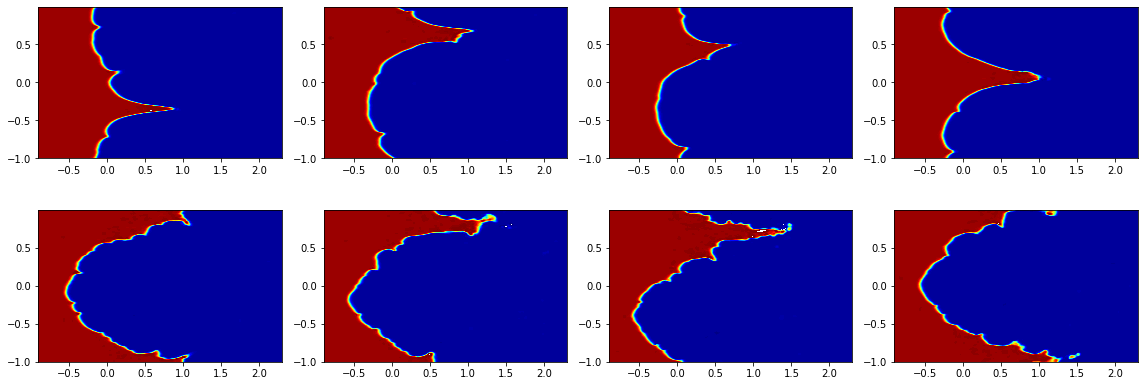

In [19]:
from matplotlib import cm
Npara = 2
Nrand = 4
#levels = np.linspace(-1,1,21,endpoint=True)
m = models[0]
k=310

fig, axs = plt.subplots(Npara,Nrand,figsize=(16,6))
for j in range(Npara):
    n=j*Nrand
    for i in range(Nrand):
        ax = axs[j,i];  
        ax.contourf( m['y']/np.pi, m['x']/np.pi, m['list_pred'][n+i,k,:,:], levels = np.linspace(-1.05,1.05, 101,endpoint=True), cmap=cm.jet  ); ax.set_aspect('equal')
        #ax.imshow( m['list_pred'][n+i,k,:,:] ); #ax.set_aspect('equal')
fig.tight_layout()


In [20]:
models[1]=update_model_pred(models[1])

std2_pConv2D_tks2_cfdL320_rho8_L1536_rho8d6_inception_less_o10  loaded in: count_learnable_params =1321319
rand_d0_simple, scale= 0.03
rand_d0_simple, scale= 0.03
rand_d0_simple, scale= 0.03
rand_d0_simple, scale= 0.03
(256,) (256,) 256 256 [-2.82743339  7.2256631 ]
(256,) (256,) 256 256 [-2.82743339  7.2256631 ]
(256,) (256,) 256 256 [-2.82743339  7.2256631 ]
(256,) (256,) 256 256 [-2.82743339  7.2256631 ]
....................................................................................................list_pred.shape= (8, 1001, 256, 256)


In [21]:

#list_i_t_plot = [0, 25,50, 100,200,300,400,500 ,600,700 ]
list_i_t_plot = [0, 25,50,100,150,200,250, 300, 350, 400, 450, 500,550,600,650, 700 ] #,900,1000,1100,1200,1300,1400]

#list_i_t_plot = [0, 25,50,75,100,125,150,175, 200,225, 250, 300] #,400,500 ,600,700 , 800] #,900,1000,1100,1200,1300,1400]


................
................
................
................
................
................
................
................
................
................
................
................
................
................
................
................


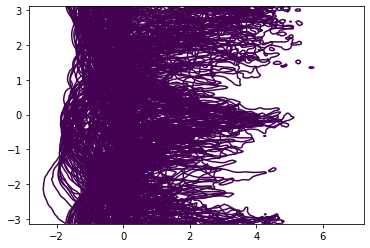

In [22]:
def extract_all_level_curves(m, list_i_t_plot ):
    list_pred_curv=[]
    for pred_2d in m['list_pred'] [:,list_i_t_plot,:,:]  :
        list_pred_curv.append( extract_levelzero_curves(m['x'], m['y'], pred_2d) )
        print('')        
    m['list_pred_curv'] = list_pred_curv
    return m
    
def extract_levelzero_curves(x, y, pred_2d):
    # m['y'], m['x'] , m['list_pred'][0,:,:,:]
    level_zero= 0
    list_pred_xy0level=[]
    for idx, each_pred in  enumerate( pred_2d) :
        cs = plt.contour( y, x, each_pred, [level_zero] )
        p  = cs.collections[0].get_paths() #[0]
        #v = p.vertices    
        list_pred_xy0level.append( p ) 
        
        #if (idx+1)%100==0:
        print('',end='.')
    return list_pred_xy0level

for m in models:
    m = extract_all_level_curves(m, list_i_t_plot)

Ny_actual= 256 ; yB/(pi)= [-0.9  2.3] , AspectRatio_set= 1.5999999999999999
here we are inspecting xy_curv[0] ...
.0.168[s]
Done for  ./Data_PRE_LaminarFlame/L512_rho8.pkl
Ny_actual= 256 ; yB/(pi)= [-0.9  2.3] , AspectRatio_set= 1.5999999999999999
here we are inspecting xy_curv[25] ...
.0.129[s]
Done for  ./Data_PRE_LaminarFlame/L512_rho8.pkl
Ny_actual= 256 ; yB/(pi)= [-0.9  2.3] , AspectRatio_set= 1.5999999999999999
here we are inspecting xy_curv[50] ...
.0.129[s]
Done for  ./Data_PRE_LaminarFlame/L512_rho8.pkl
Ny_actual= 256 ; yB/(pi)= [-0.9  2.3] , AspectRatio_set= 1.5999999999999999
here we are inspecting xy_curv[100] ...
.0.128[s]
Done for  ./Data_PRE_LaminarFlame/L512_rho8.pkl
Ny_actual= 256 ; yB/(pi)= [-0.9  2.3] , AspectRatio_set= 1.5999999999999999
here we are inspecting xy_curv[150] ...
.0.128[s]
Done for  ./Data_PRE_LaminarFlame/L512_rho8.pkl
Ny_actual= 256 ; yB/(pi)= [-0.9  2.3] , AspectRatio_set= 1.5999999999999999
here we are inspecting xy_curv[200] ...
.0.130[s]
Done for

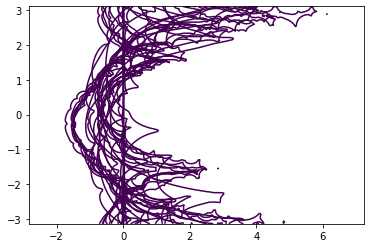

In [23]:
def compute_sys_G(sys, list_i_t_plot):
    pkl_filename ='./Data_PRE_LaminarFlame/' + sys['cfd']+'.pkl' 
    G = []
    for i_t in list_i_t_plot: 
        G_i_t, _  = libcfdData.get_levelsetG2D( pkl_filename, params['Nx'] , params['yB'], i_t, AspectRatio_set = (2.3+0.9)/2 ) 
        G_i_t     = np.tanh( G_i_t/ params['ThicknessScale'] ) 
        G.append(G_i_t.squeeze())
    return np.array(G)

sys = get_2d_cfd_sys('L512_rho8') #'L320_rho8'
sys1_G = compute_sys_G(sys, list_i_t_plot)

sys = get_2d_cfd_sys('L1536_rho8')
sys2_G = compute_sys_G(sys, list_i_t_plot)

sys1_xy = extract_levelzero_curves( models[0]['x'],  models[0]['y'], sys1_G)
sys2_xy = extract_levelzero_curves( models[0]['x'],  models[0]['y'], sys2_G)


In [24]:
#Npara
Nrand

4

In [25]:
from matplotlib.pyplot import cm
import itertools

def plot_disp_long(list_model_name__iList_rand, png_filename=None,   list_i_t_plot= list_i_t_plot, rd=100  ): 
    #, iList_rand = [ [0, 0],[0,0] ] ):
    
    #figsize=(0.9*11.7,0.9*4.9* (0.5+len(list_model_name))   )
    
    #colors = cm.rainbow( np.linspace(0,1,len(list_i_t_plot) ) )   
    #color_s = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    figsize=(15, 2.9*(1+len(list_model_name__iList_rand))   )
    #---------------------------------------------------------------------------
    fig, axs = plt.subplots( 1+len(list_model_name__iList_rand),2, sharex=True, sharey=True, figsize= figsize )
    #-----------------------
    for ax in axs.flat:
        #---------------------
        #for ax in ax_cols:
        ax.set_yticks( [-np.pi,  np.pi] ); 
        ax.set_yticklabels(['$-\pi$', '$\pi$'] ,  fontsize=14,rotation='vertical')
        ax.set_ylabel('$2\pi x_1/\Lambda$ ', fontsize=14, labelpad=0)

        ax.set_xlim ( [-0.2, 5.8*np.pi] )
        ax.set_xlabel('$2\pi x_2 /\Lambda  $ + j/'+str(rd), fontsize=14 )
        ax.set_xticks( [ 0,  2*np.pi,  4*np.pi,  5*np.pi  ]);    
        ax.set_xticklabels(['0','2$\pi$', '4$\pi$' ,'5$\pi$' ] , fontsize=14 )
        #ax.set_xticklabels([] , fontsize=14 )
        #---------------------
        ax.set_aspect('equal')
    #---------------------------
    
    #---------------------------------
    for k_para in range(Npara):
        
        ax = axs[0,k_para]
        
        # if k_para==0:       sys = get_2d_cfd_sys('L512_rho8')
        # else:               sys = get_2d_cfd_sys('L1536_rho8')
        # for i in list_i_t_plot:
        #     d = (i)/rd
        #     if i >= 0  and i< len(sys['xyCurv'])-1: 
        #         yx = sys['xyCurv'][i]
        #         h_pred, = ax.plot(  yx[:,0] + d,   yx[:,1], '.' , markersize=.025 )  
        # #---------------------------------------         
        if k_para == 0: xy = sys1_xy
        else:           xy = sys2_xy
    
        colors = itertools.cycle( plt.rcParams['axes.prop_cycle'].by_key()['color'] )
        for idx_t, (i , c) in enumerate( zip(list_i_t_plot, colors) ):
            d =  (i)/rd
            #if i >= 0: 
            for idx, each_line_seg in enumerate( xy[idx_t]) :
                v = each_line_seg.vertices    
                h_pred, = ax.plot(  v[:,0] + d,   v[:,1], c=c ,lw=1)  
        
        if k_para == 0:  ax.set_title('$\mu$={}'.format(0.033), fontsize= 14 ) 
        else:            ax.set_title('$\mu$={}'.format(0.011), fontsize= 14)     

        if k_para == Npara -1: 
            ax.yaxis.set_label_position("right")
            ax.set_ylabel( 'Ref' , fontsize=14)                
        


    
    for i_model, (model_name, iList_rand ) in enumerate( list_model_name__iList_rand):
        #------------------
        m = get_model( model_name )
        #------------------
        
        #for ax, pred in zip( axs[ 1+ i_model*nRow:( 1+ i_model+1)*nRow,...].reshape(-1),  m['list_pred_curv'][ i_rand:nRow*Nrand : Nrand] ) :
        
        for k_para in range(Npara):
            
            ax = axs[1+i_model,k_para]
            
            #pred = m['list_pred_curv'][ iList_rand[i_model][k_para] + k_para*Nrand ]
            pred = m['list_pred_curv'][ iList_rand[k_para] + k_para* Nrand  ] 
            

            colors = itertools.cycle( plt.rcParams['axes.prop_cycle'].by_key()['color'] )
            for idx_t, (i , c) in enumerate( zip(list_i_t_plot, colors) ):
                d =  (i)/rd
                for idx, each_line_seg in enumerate( pred[idx_t]):
                    v = each_line_seg.vertices    
                    h_pred, = ax.plot(  v[:,0] + d,   v[:,1] , c=c, lw=1)  
                    #if idx==0:
                    #h_pred, = ax.plot(  v[:,0] + d,   v[:,1] , lw=1)  
                    #else:
                    #    h_pred, = ax.plot(  v[:,0] + d,   v[:,1],  lw=1 )  

                #h_ref, = ax.plot(  d_an[i] + d,   x,'--k' , linewidth=1 )

            if k_para == Npara -1: 
                ax.yaxis.set_label_position("right")
                ax.set_ylabel( model_name , fontsize=14)                
            
    for ax in axs.flat:
        ax.label_outer()
    #fig.legend([h_ref,h_pred],['Ref',model_name], bbox_to_anchor=(0.6,0.1),ncol=2,fontsize=14  )

    fig.tight_layout()
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    

    
    if png_filename is not None:
        print('savefig: ', png_filename)
        if 'eps' in png_filename:
            plt.savefig(png_filename,format = 'eps')
        else:
            plt.savefig(png_filename, dpi=300)
    #return fig,axs

savefig:  disp2d.eps


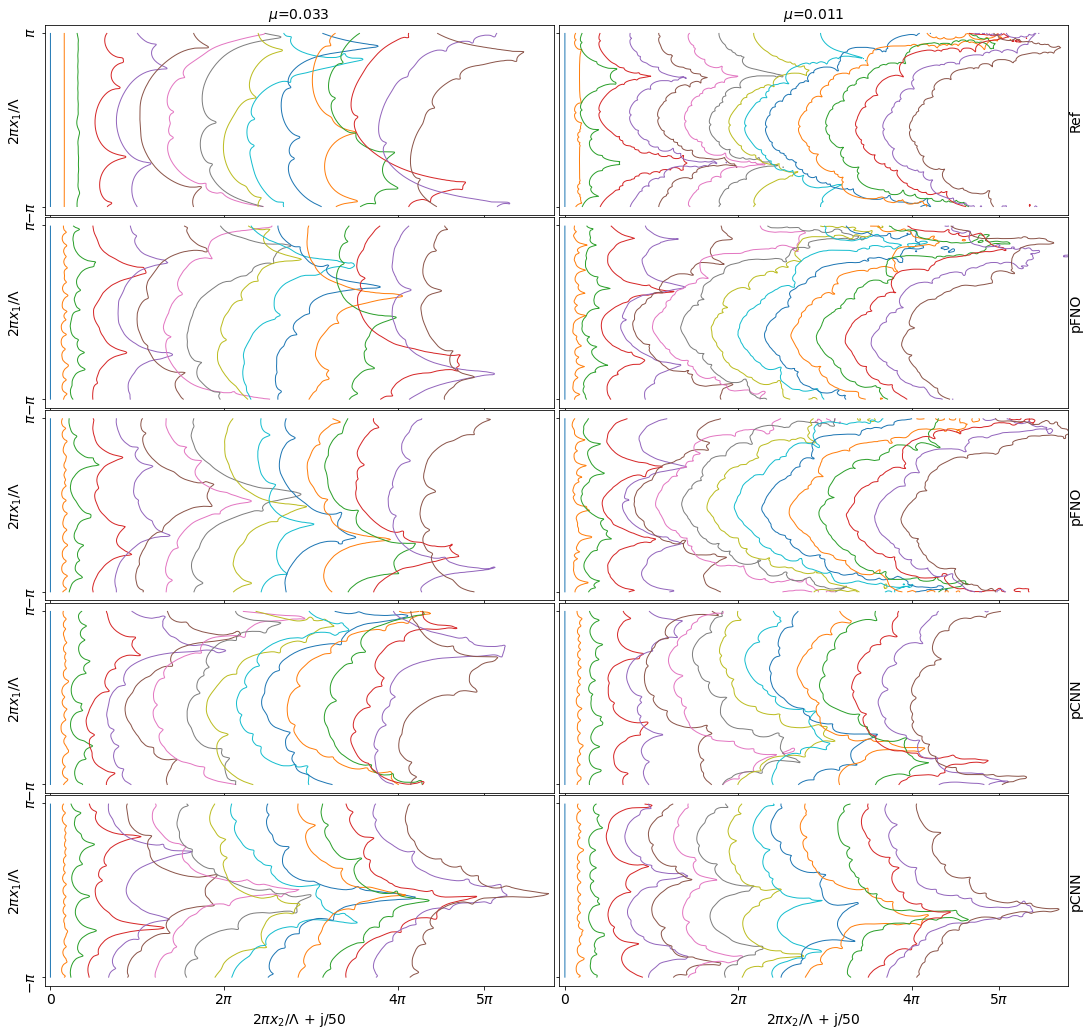

In [26]:
png_filename = 'disp2d.eps'

#plot_disp_long(['pFNO','pCNN'],list_i_t_plot=list_i_t_plot, rd=50, png_filename=png_filename,iList_rand=[[2,2],[1,3]] ) # 'RISE_2d_all.png')

plot_disp_long([ ['pFNO', [1,1] ],['pFNO', [3,3] ], ['pCNN', [1,1] ], ['pCNN', [3,3] ]  ],
               list_i_t_plot=list_i_t_plot, rd=50, png_filename=png_filename ) # 'RISE_2d_all.png')


In [671]:

#plot_disp_long(['CNN'],list_i_t_plot=list_i_t_plot, rd=50, png_filename=None,iList_rand=[[2,1]] ) # 'RISE_2d_all.png')


In [27]:
def plot_G2D(list_model_name, png_filename=None, i_t__plotpick =[(1,200), (1,2000)] ):
    
    fig, axs = plt.subplots( len(list_model_name),2, sharex=True, sharey=True, figsize=(12 ,4*len(list_model_name)) )
    #fig, axs = plt.subplots( len(list_model_name),2,  figsize=(12,4*len(list_model_name)) ,constrained_layout=True )

    for i_model, model_name in enumerate(list_model_name):
        
        m = get_model( model_name )
        
        for i_t, ax in zip( i_t__plotpick, axs[i_model:i_model+1,:].reshape(-1) ) :

            #print( m['list_pred'].shape, i_t) 
            cs = ax.contourf( m['y'], m['x'],  m['list_pred'][i_t], levels = np.linspace(-1.1,1.1, 21,endpoint=True),   vmin=-1.1, vmax=1.1 )

            ax.set_aspect('equal')
            #---------------------
            #for ax in ax_cols:
            ax.set_ylim ( [-np.pi, np.pi] )
            if i_model == 0: 
                ax.set_yticks( [-np.pi, 0, np.pi] ); 
                ax.set_yticklabels(['$-\pi$', '0', '$\pi$'] ,  fontsize=14,rotation='vertical')
            else:
                ax.set_yticks( [-np.pi, 0] ); 
                ax.set_yticklabels(['$-\pi$', '0'] ,  fontsize=14,rotation='vertical')
            ax.set_ylabel('$2\pi x_1/\Lambda$', fontsize=14, labelpad=0)
            
            #ax.set_title( 'j='+str(i_t[1]) )

            #ax.set_xlim ( [-0.3, 8.2*np.pi] )
            ax.set_xlabel('$2\pi x_2/\Lambda$', fontsize=14 )
            ax.set_xticks( [ 0,  2*np.pi] );    
            ax.set_xticklabels(['0','2$\pi$' ] , fontsize=14 )
            
            #---------------------

    #plt.subplots_adjust(wspace=0.02,hspace=0.02)
    
    for ax in axs.flat:
        ax.label_outer()    
    #fig.tight_layout()
    
    
    plt.subplots_adjust(left=0.045,right=0.915-0.03, top=0.95,  wspace=0.02, hspace=0.02)
    
    list_RightText = [ nmodel_name for nmodel_name in list_model_name[::-1]]
    dy =(1-0.1)/len(list_model_name) 
    for idx in range( len(list_model_name)):
        ypos = 0.1+(0.5+idx)*dy
        fig.text(0.92-0.03, ypos, list_RightText[idx],  rotation='vertical',fontsize=16 ,transform=plt.gcf().transFigure) #, weight='bold')

    cbaxes = fig.add_axes([0.96-0.03, 0.35, 0.02, 0.4])        
    cbar = fig.colorbar(cs,   shrink=1, ticks=[-1, 0, 1] , cax = cbaxes )  #ax=axs,
    cbar.ax.set_ylabel('$\Psi(x_1,x_2;t_j)$',fontsize=16)

    #cbar.ax.tick_params(labelsize=16)
    #cbar.ax.tick_params(labelsize=14)
    #---------------------
    #----        
    #print (get(cb).Position)
    #set(cb,'Position',[a(1)+dx a(2)+dy w h])%

    fig.text( 0.25, 0.96, 'j='+str(i_t__plotpick[0][-1]) , ha='center',fontsize=16)
    fig.text( 0.7, 0.96, 'j='+str(i_t__plotpick[1][-1]) , ha='center',fontsize=16 )    
    
    if png_filename is not None:
        print('savefig: ', png_filename)
        if 'eps' in png_filename:
            plt.savefig(png_filename,format = 'eps')
        else:
            plt.savefig(png_filename, dpi=300)
    

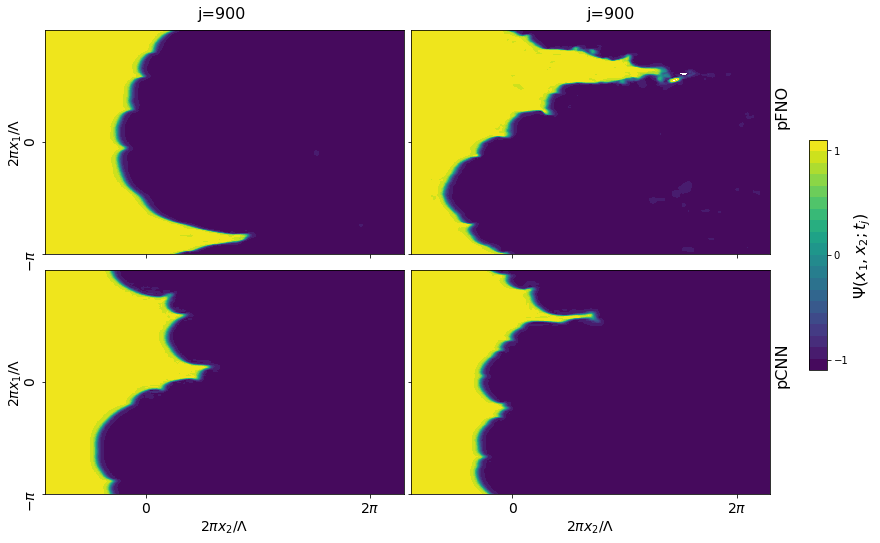

In [28]:
#plot_G2D(list_model_name= ['FNO','CAS'],  png_filename='G2D_fourier_L536_rho8.png', i_t__plotpick =[(1,200), (1,2000)] )


#plot_G2D(list_model_name= ['pFNO','pCNN'],  png_filename='G2D.png', i_t__plotpick =[(1,200), (1,2000)] )
plot_G2D(list_model_name= ['pFNO','pCNN'],  png_filename=None, i_t__plotpick =[(1,900), (5,900)] )
